## Module Import & Data Load

In [1]:
import sys

from pathlib import Path
from datetime import timedelta

import dateutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange
from TaPR_pkg import etapr
from src import dataset
import random
import pickle
from torchinfo import summary

ModuleNotFoundError: No module named 'src'

In [ ]:
import transformers
from models.gpt2 import GPT2Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

In [ ]:
def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)

set_seed(72)

In [ ]:
WINDOW_GIVEN = 89
WINDOW_SIZE = 90


class HaiDataset(Dataset):
    def __init__(self, timestamps, df, stride=1, attacks=None):
        self.ts = np.array(timestamps)
        self.tag_values = np.array(df, dtype=np.float32)
        self.valid_idxs = []
        for L in trange(len(self.ts) - WINDOW_SIZE + 1):
            R = L + WINDOW_SIZE - 1
            if dateutil.parser.parse(self.ts[R]) - dateutil.parser.parse(
                self.ts[L]
            ) == timedelta(seconds=WINDOW_SIZE - 1):
                self.valid_idxs.append(L)
        self.valid_idxs = np.array(self.valid_idxs, dtype=np.int32)[::stride]
        self.n_idxs = len(self.valid_idxs)
        print(f"# of valid windows: {self.n_idxs}")
        if attacks is not None:
            self.attacks = np.array(attacks, dtype=np.float32)
            self.with_attack = True
        else:
            self.with_attack = False

    def __len__(self):
        return self.n_idxs

    def __getitem__(self, idx):
        i = self.valid_idxs[idx]
        last = i + WINDOW_SIZE - 1
        item = {"attack": self.attacks[last]} if self.with_attack else {}
        item["ts"] = self.ts[i + WINDOW_SIZE - 1]
        item["given"] = torch.from_numpy(self.tag_values[i : i + WINDOW_GIVEN])
        item["answer"] = torch.from_numpy(self.tag_values[last])
        return item

In [ ]:
def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

In [ ]:
TRAIN_DATASET = sorted([x for x in Path("HAICon2021_dataset/train/").glob("*.csv")])
TRAIN_DATASET

In [ ]:
TEST_DATASET = sorted([x for x in Path("HAICon2021_dataset/test/").glob("*.csv")])
TEST_DATASET

In [ ]:
VALIDATION_DATASET = sorted([x for x in Path("HAICon2021_dataset/validation/").glob("*.csv")])
VALIDATION_DATASET

In [ ]:
def dataframe_from_csv(target):
    return pd.read_csv(target).rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

In [ ]:
TRAIN_DF_RAW = dataframe_from_csvs(TRAIN_DATASET)
TRAIN_DF_RAW

In [ ]:
TIMESTAMP_FIELD = "timestamp"
IDSTAMP_FIELD = 'id'
ATTACK_FIELD = "attack"
VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW.columns.drop([TIMESTAMP_FIELD])
VALID_COLUMNS_IN_TRAIN_DATASET

In [ ]:
TAG_MIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min()
TAG_MAX = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max()

In [ ]:
def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

In [ ]:
TRAIN_DF = normalize(TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TRAIN_DF

In [ ]:
HAI_DATASET_TRAIN = HaiDataset(TRAIN_DF_RAW[TIMESTAMP_FIELD], TRAIN_DF, stride=10)
HAI_DATASET_TRAIN[0]

In [ ]:
VALIDATION_DF_RAW = dataframe_from_csvs(VALIDATION_DATASET)
VALIDATION_DF_RAW

In [ ]:
VALIDATION_DF = normalize(VALIDATION_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])

In [ ]:
HAI_DATASET_VALIDATION = HaiDataset(
    VALIDATION_DF_RAW[TIMESTAMP_FIELD], VALIDATION_DF, attacks=VALIDATION_DF_RAW[ATTACK_FIELD]
)
HAI_DATASET_VALIDATION[0]

In [ ]:
boundary_check(VALIDATION_DF)

In [ ]:
TEST_DF_RAW = dataframe_from_csvs(TEST_DATASET)
TEST_DF_RAW

In [ ]:
TEST_DF = normalize(TEST_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TEST_DF

In [ ]:
boundary_check(TEST_DF)

In [ ]:
HAI_DATASET_TEST = HaiDataset(
    TEST_DF_RAW[TIMESTAMP_FIELD], TEST_DF, attacks=None
)
HAI_DATASET_VALIDATION[0]

In [27]:
params = {'batch_size': 512,
          'shuffle': True,
          'num_workers': 4,
          'pin_memory' : True}
trainloader = DataLoader(HAI_DATASET_TRAIN, **params)
params['shuffle'] = False
validloader = DataLoader(HAI_DATASET_VALIDATION, **params)
testloader = DataLoader(HAI_DATASET_TEST, **params)

In [28]:
train_shape = next(iter(trainloader))['given'].shape
print(train_shape)

torch.Size([512, 89, 86])


## Model

In [29]:
class HAIGPT(nn.Module):

    def __init__(
            self,
            input_dim,
            hidden_size,
            max_len=89,
            device='cuda',
            **kwargs
    ):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_size = hidden_size
        self.device = device
        config = transformers.GPT2Config(
            vocab_size=1,  # doesn't matter -- we don't use the vocab
            n_embd=hidden_size,
            **kwargs
        )

        # note: the only difference between this GPT2Model and the default Huggingface version
        # is that the positional embeddings are removed (since we'll add those ourselves)
        self.transformer = GPT2Model(config)

        self.pos_embedding = nn.Parameter(torch.randn(1, max_len, hidden_size))
        self.embed_token = nn.Linear(self.input_dim, hidden_size)

        self.embed_ln = nn.LayerNorm(hidden_size)

        self.predict = nn.Linear(hidden_size, self.input_dim)

    def forward(self, token, attention_mask=None):

        batch_size, seq_length = token.shape[0], token.shape[1]

        if attention_mask is None:
            # attention mask for GPT: 1 if can be attended to, 0 if not
            attention_mask = torch.ones((batch_size, seq_length), dtype=torch.long).to(self.device)

        # embed each modality with a different head
        token_embeddings = self.embed_token(token)

        # time embeddings are treated similar to positional embeddings
        token_embeddings = token_embeddings + self.pos_embedding

        # which works nice in an autoregressive sense since states predict actions
        inputs = self.embed_ln(token_embeddings)

        # we feed in the input embeddings (not word indices as in NLP) to the model
        transformer_outputs = self.transformer(
            inputs_embeds=inputs,
            attention_mask=attention_mask,
        )
        x = transformer_outputs['last_hidden_state']
        
        # get predictions
        preds = self.predict(x)  

        return preds[:,-1]

In [30]:
train_shape[1:]

torch.Size([89, 86])

In [31]:
input_shape = train_shape[1:]
model = HAIGPT(
    input_dim=input_shape[-1],
    hidden_size=128,
    max_len=89,
    n_layer=3,
    n_head=1,
    n_inner=4*128,
    activation_function='relu',
    n_positions=1024,
    resid_pdrop=0.1,
    attn_pdrop=0.1,
).to(device)

In [63]:
print(model)

HAIGPT(
  (transformer): GPT2Model(
    (wte): Embedding(1, 128)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((128,), eps=1e-05, elementwise_affine=T

In [99]:
optimizer = optim.AdamW(model.parameters())
loss_fn = nn.MSELoss()

In [95]:
print(model(next(iter(trainloader))['given'].to(device)).shape)

torch.Size([512, 89, 128])
torch.Size([512, 86])


In [77]:
def train(model, train_data, optimizer, loss_fn, use_fp16=True, max_norm=None):
    
    epoch_loss = 0
    
    model.train() 

    for idx, batch in enumerate(train_data):
        
        optimizer.zero_grad(set_to_none=True)
        scaler = torch.cuda.amp.GradScaler()
                
        input = batch['given'].to(device)
        answer = batch["answer"].to(device)
        
        with torch.cuda.amp.autocast(enabled=use_fp16):
            predictions = model.forward(input)
            train_loss = loss_fn(predictions, answer)
        if use_fp16:
            scaler.scale(train_loss).backward()
            if max_norm is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            scaler.step(optimizer)
            scaler.update()
        else:
            train_loss.backward()
            optimizer.step()
        
        epoch_loss += train_loss.item()
        
    return epoch_loss

In [78]:
def validation(model, val_data, loss_fn):
    model.eval()
    val_loss = 0
    for idx, batch in enumerate(val_data):
        input = batch['given'].to(device)
        answer = batch["answer"].to(device)
        with torch.no_grad():
            predictions = model.forward(input)
            val_loss += loss_fn(predictions, answer).item()
        
    return val_loss

In [79]:
class EarlyStopping():
    def __init__(self, patience=0, verbose=0):
        self._step = 0
        self._loss = float('inf')
        self.patience = patience
        self.verbose = verbose

    def validate(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print(f'\n Training process is stopped early....')
                return True
        else:
            self._step = 0
            self._loss = loss

        return False

In [100]:
%%time
epochs = 300
history = dict()
best = {"loss": sys.float_info.max}
early_stopping = EarlyStopping(patience=30, verbose=1)
for epoch in range(1, epochs+1):
    epoch_loss = train(model, trainloader, optimizer, loss_fn, use_fp16=False)
    val_loss = validation(model, validloader, loss_fn)
    
    history.setdefault('loss', []).append(epoch_loss) 
    history.setdefault('val_loss', []).append(val_loss) 
    
    sys.stdout.write(
        "\r" + f"[Train] Epoch : {epoch:^3}"\
        f"  Train Loss: {epoch_loss:.4}"\
        f"  Validation Loss: {val_loss:.4}"\
                    )
#     print(f"[Train] Epoch : {epoch:^3}"\
#         f"  Train Loss: {epoch_loss:.4}"\
#         f"  Validation Loss: {val_loss:.4}")
    if epoch_loss < best["loss"]:
            best["state"] = model.state_dict()
            best["loss"] = epoch_loss
            best["epoch"] = epoch + 1
    if early_stopping.validate(epoch_loss):
        break

[Train] Epoch : 300  Train Loss: 0.03553  Validation Loss: 0.2354CPU times: user 2h 21min 47s, sys: 7min 35s, total: 2h 29min 23s
Wall time: 1h 10min 13s


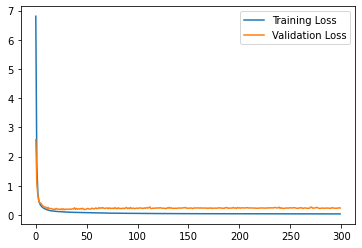

In [101]:
plt.plot(history["loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [49]:
model.load_state_dict(best["state"])

<All keys matched successfully>

In [32]:
model.load_state_dict(torch.load('./checkpoints/GPT_89.tar')['model'])

<All keys matched successfully>

In [33]:
def inference(dataloader, model):
    ts, dist, att = [], [], []
    with torch.no_grad():
        for batch in dataloader:
            given = batch['given'].to(device)
            answer = batch["answer"].to(device)
            guess = model(given)
            ts.append(np.array(batch["ts"]))
            dist.append(torch.abs(answer - guess).cpu().numpy())
#             dist.append(torch.sum(torch.abs(guess-given), 1).cpu().numpy())
            try:
                att.append(np.array(batch["attack"]))
            except:
                att.append(np.zeros(given.shape[0]))
            
    return (
        np.concatenate(ts),
        np.concatenate(dist),
        np.concatenate(att),
    )

In [94]:
%%time
model.eval()
CHECK_TS, CHECK_DIST, CHECK_ATT = inference(validloader, model)

CPU times: user 10.1 s, sys: 605 ms, total: 10.7 s
Wall time: 3.33 s


In [95]:
ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)

In [36]:
def check_graph(xs, att, piece=2, THRESHOLD=None):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
        if len(xs[L:R]) > 0:
            peak = max(xs[L:R])
            axs[i].plot(xticks, att[L:R] * peak * 0.3)
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
    plt.show()

In [37]:
def range_check(series, size):
    size = size
    data = []

    for i in range(len(series)-size+1):
        if i == 0 :
            check_std = np.std(series[i:i+size])
        std = np.std(series[i:i+size])
        mean = np.mean(series[i:i+size])
        max = np.max(series[i:i+size])
        if check_std * 2 >= std:
            check_std = std
            data.append(mean)
        elif max == series[i]:
            data.append(max*5)
            check_std = std
        else:
            data.append(series[i]*3)
    for _ in range(size-1):
        data.append(mean)

    return np.array(data)

In [96]:
C_ANOMALY_SCORE = range_check(ANOMALY_SCORE, size=30)

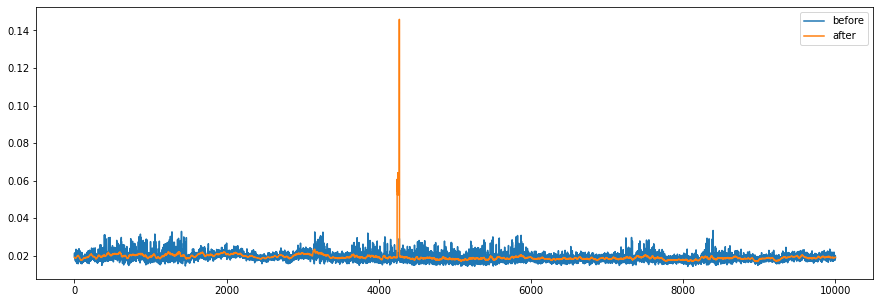

In [39]:
plt.figure(figsize=(15,5))
plt.plot(ANOMALY_SCORE[10000:20000], label='before')
plt.plot(C_ANOMALY_SCORE[10000:20000], label='after')
plt.legend()
plt.show()

In [40]:
CHECK_ATT

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

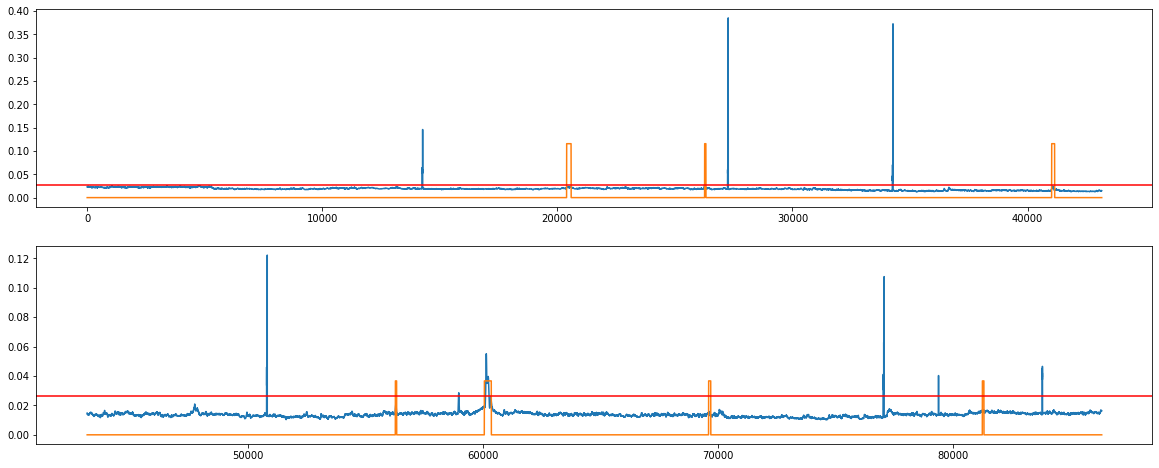

In [97]:
THRESHOLD = 0.0265
check_graph(C_ANOMALY_SCORE, CHECK_ATT, piece=2, THRESHOLD=THRESHOLD)

In [98]:
def put_labels(distance, threshold):
    xs = np.zeros_like(distance)
    xs[distance > threshold] = 1
    return xs

In [99]:
LABELS = put_labels(C_ANOMALY_SCORE, THRESHOLD)
LABELS, LABELS.shape

(array([0., 0., 0., ..., 0., 0., 0.]), (86311,))

In [100]:
ATTACK_LABELS = put_labels(np.array(VALIDATION_DF_RAW[ATTACK_FIELD]), threshold=THRESHOLD)
ATTACK_LABELS, ATTACK_LABELS.shape

(array([0, 0, 0, ..., 0, 0, 0]), (86400,))

In [46]:
def fill_blank(check_ts, labels, total_ts):
    def ts_generator():
        for t in total_ts:
            yield dateutil.parser.parse(t)

    def label_generator():
        for t, label in zip(check_ts, labels):
            yield dateutil.parser.parse(t), label

    g_ts = ts_generator()
    g_label = label_generator()
    final_labels = []

    try:
        current = next(g_ts)
        ts_label, label = next(g_label)
        while True:
            if current > ts_label:
                ts_label, label = next(g_label)
                continue
            elif current < ts_label:
                final_labels.append(0)
                current = next(g_ts)
                continue
            final_labels.append(label)
            current = next(g_ts)
            ts_label, label = next(g_label)
    except StopIteration:
        return np.array(final_labels, dtype=np.int8)

In [101]:
%%time
FINAL_LABELS = fill_blank(CHECK_TS, LABELS, np.array(VALIDATION_DF_RAW[TIMESTAMP_FIELD]))
FINAL_LABELS.shape

CPU times: user 15 s, sys: 0 ns, total: 15 s
Wall time: 15 s


(86400,)

In [102]:
TaPR = etapr.evaluate_haicon(anomalies=ATTACK_LABELS, predictions=FINAL_LABELS)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

F1: 0.203 (TaP: 0.210, TaR: 0.197)
# of detected anomalies: 2
Detected anomalies: [<TaPR_pkg.DataManage.Range.Range object at 0x7f5e8e73c048>, <TaPR_pkg.DataManage.Range.Range object at 0x7f5e8e73c128>]


In [103]:
%%time
model.eval()
CHECK_TS, CHECK_DIST, CHECK_ATT = inference(testloader, model)

CPU times: user 31.9 s, sys: 1.59 s, total: 33.5 s
Wall time: 9.92 s


In [104]:
ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)

In [105]:
C_ANOMALY_SCORE = range_check(ANOMALY_SCORE, size=30)

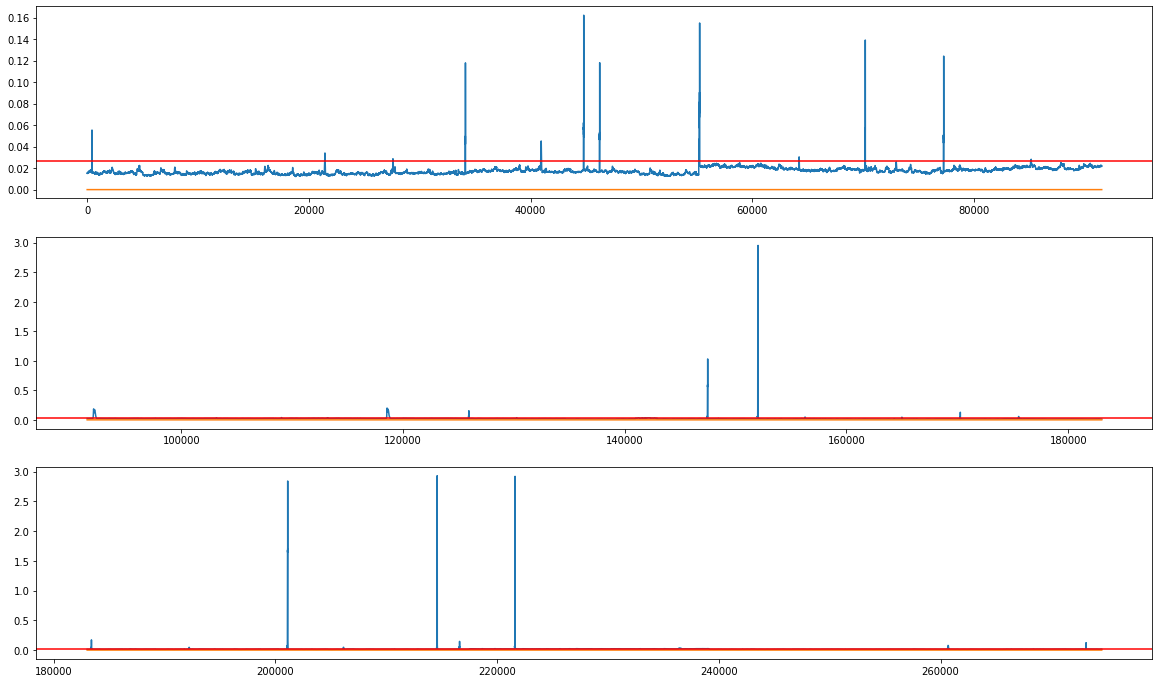

In [106]:
check_graph(C_ANOMALY_SCORE, CHECK_ATT, piece=3, THRESHOLD=THRESHOLD)

In [107]:
LABELS = put_labels(C_ANOMALY_SCORE, THRESHOLD)
LABELS, LABELS.shape

(array([0., 0., 0., ..., 0., 0., 0.]), (274533,))

In [108]:
submission = pd.read_csv('./HAICon2021_dataset/sample_submission.csv')
submission.index = submission['timestamp']
submission.loc[CHECK_TS,'attack'] = LABELS
submission

,timestamp,attack
timestamp,,
2021-07-13 16:00:01,2021-07-13 16:00:01,0.0
2021-07-13 16:00:02,2021-07-13 16:00:02,0.0
2021-07-13 16:00:03,2021-07-13 16:00:03,0.0
2021-07-13 16:00:04,2021-07-13 16:00:04,0.0
2021-07-13 16:00:05,2021-07-13 16:00:05,0.0
...,...,...
2021-07-16 23:59:56,2021-07-16 23:59:56,0.0
2021-07-16 23:59:57,2021-07-16 23:59:57,0.0
2021-07-16 23:59:58,2021-07-16 23:59:58,0.0


In [109]:
submission.to_csv('baseline.csv', index=False)

In [173]:
torch.save({'model': model.state_dict(), 
                'Threshold': 0.025, 
               }, './checkpoints/GPT_89.tar')

----